In [ ]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import keras
import tensorflow as tf


PLOTS_DIR = f"plots/assignment_transformer_high_level_features/"
MODEL_DIR = f"models/assignment_transformer_high_level_features/"
CONFIG_PATH = "../config/workspace_config_high_level_features.yaml"

import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)

with open(CONFIG_PATH, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz("../../DATA/nominal.npz", max_events=1000000)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)
del DataProcessor

In [2]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name="Transformer")

TransformerMatcher.load_model(MODEL_DIR + "model.keras")

TransformerMatcher.adapt_normalization_layers(X_train)

TransformerMatcher.compile_model(
    loss={
        "assignment": core.utils.AssignmentLoss(lambda_excl=0.0),
    },
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    metrics={
        "assignment": [core.utils.AssignmentAccuracy()],
    },
)
TransformerMatcher.model.summary()

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.
Model loaded from models/assignment_transformer_high_level_features/model.keras
Training history loaded from models/assignment_transformer_high_level_features/model_history.npz


Model: "FeatureConcatTransformerModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ met_inputs          │ (None, 1, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_inputs          │ (None, 2, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_transform │ (None, 1, 2)      │          0 │ met_inputs[0][0]  │
│ (InputMetPhiLayer)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_transform │ (None, 2, 4)      │          0 │ lep_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_inputs          │ (None, 6, 9)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ met_input_normaliz… │ (None, 1, 2)      │          5 │ met_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lep_input_normaliz… │ (None, 2, 4)      │          9 │ lep_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_transform │ (None, 6, 9)      │          0 │ jet_inputs[0][0]  │
│ (InputPtEtaPhiELay… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ met_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ lep_input_normal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_input_normaliz… │ (None, 6, 9)      │         19 │ jet_input_transf… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 6, 2)      │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 6, 8)      │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6, 19)     │          0 │ jet_input_normal… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_embedding (MLP) │ (None, 6, 64)     │      4,530 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ jet_mask            │ (None, 6, 1)      │          0 │ jet_inputs[0][0]  │
│ (GenerateMask)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_blo… │ (None, 6, 64)     │     33,472 │ jet_embedding[0]… │
│ (SelfAttentionBloc… │                   │            │ jet_mask[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 206,835 (807.96 KB)

 Trainable params: 206,802 (807.82 KB)

 Non-trainable params: 33 (144.00 B)

In [3]:
TransformerMatcher.train_model(
    epochs=0,
    X_train=X_train,
    y_train=y_train,
    sample_weights=core.utils.compute_sample_weights(X_train, y_train),
    batch_size=1024,
)

In [4]:
TransformerMatcher.save_model(MODEL_DIR + "model.keras")

Model saved to models/assignment_transformer_high_level_features/model.keras


In [5]:
import core.assignment_models.BaselineAssignmentMethods as BaselineMethods
import core.reconstruction as Evaluation

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square_true_nu = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=False,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)
chi_square = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)


ground_truth_assigner = Evaluation.GroundTruthReconstructor(
    data_config, name="True Assignment"
)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        ground_truth_assigner,
        # delta_r_assigner,
        chi_square_true_nu,
        chi_square,
        TransformerMatcher,
    ],
    X_val,
    y_val,
)


Computing bootstrap confidence intervals...
True Assignment: Ground Truth (skipping)
$\chi^2$-Method($\nu^2$-Flows): 0.6093 [0.6065, 0.6122]
$\chi^2$-Method($\nu^2$-Flows): 0.6093 [0.6064, 0.6124]
Transformer: 0.7953 [0.7928, 0.7978]


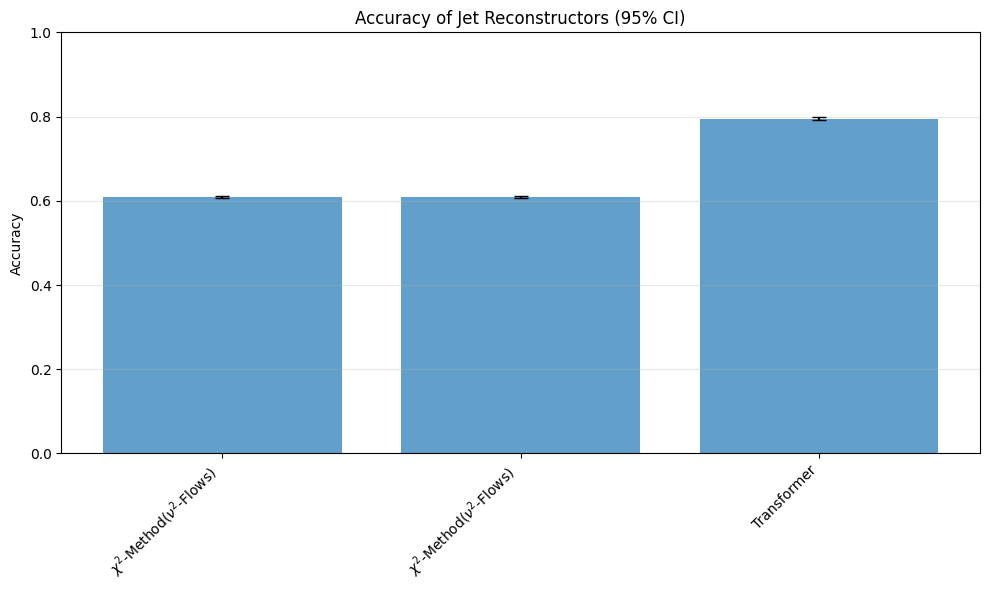

In [6]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


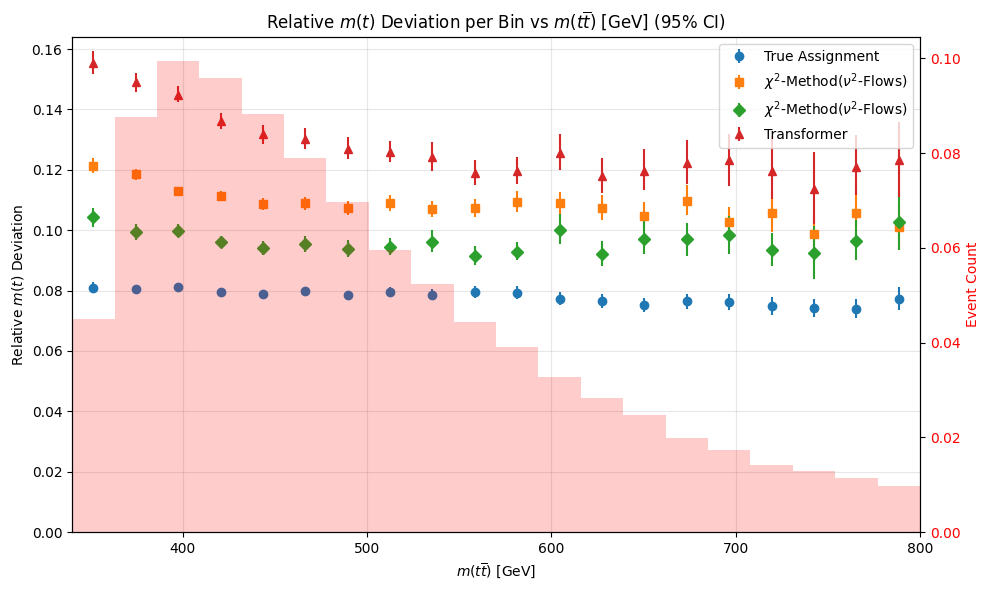

In [7]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


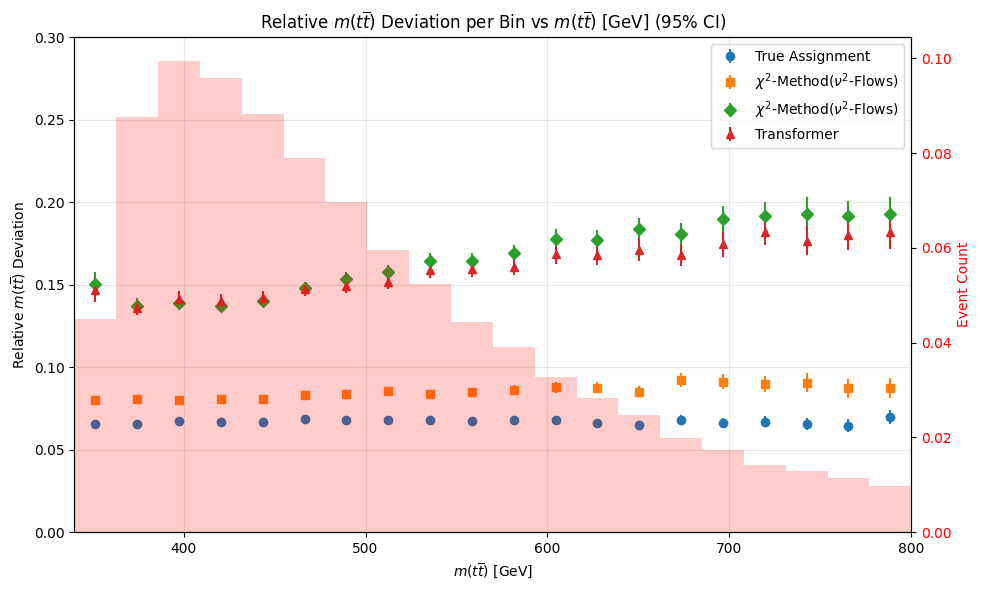

In [8]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
ax.set_ylim(0, 0.3)
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned complementarity for truth_ttbar_mass...


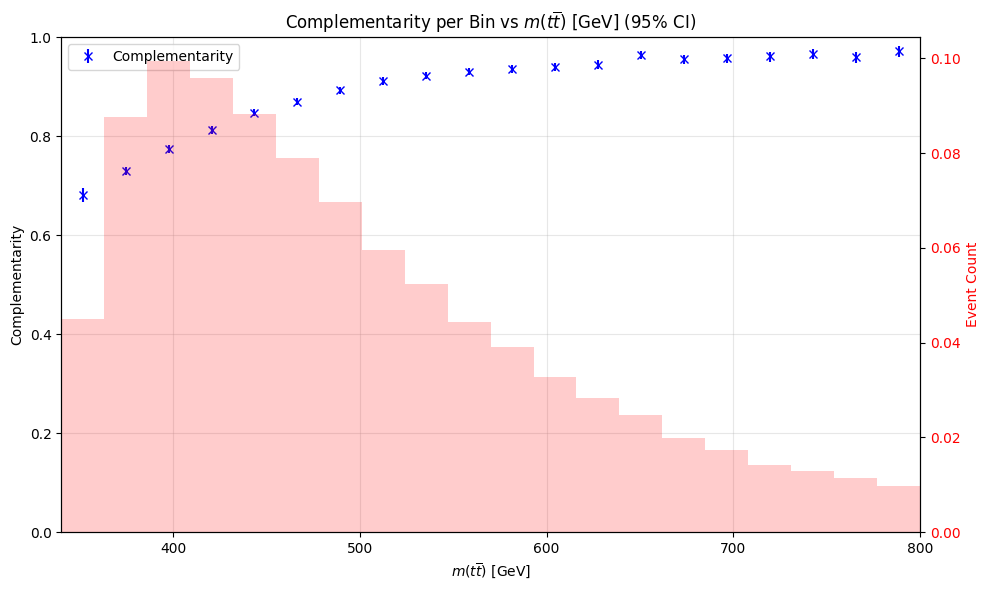

In [9]:
fig, ax = evaluator.plot_binned_complementarity(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_complementarity_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_mass...


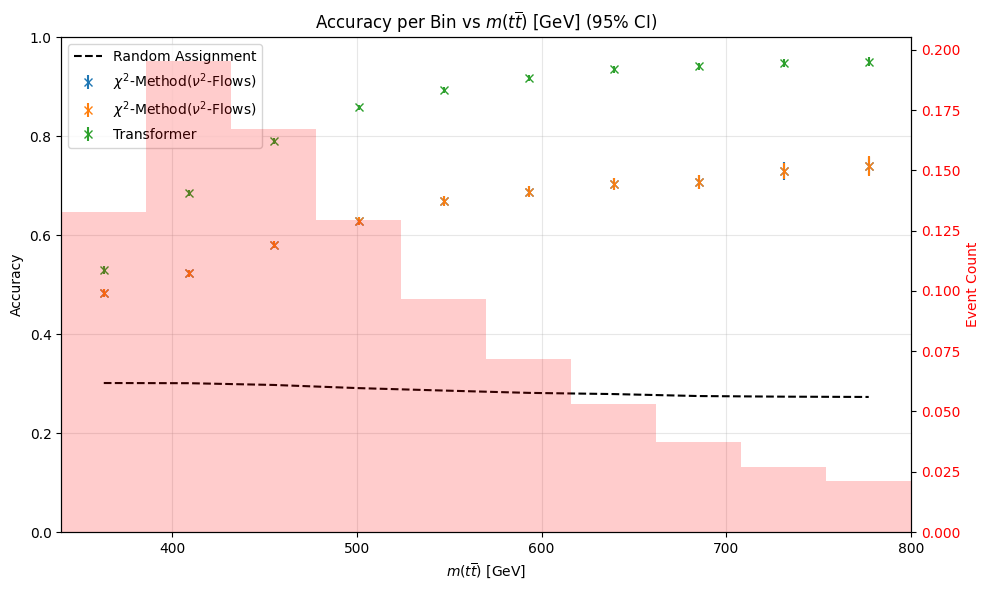

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


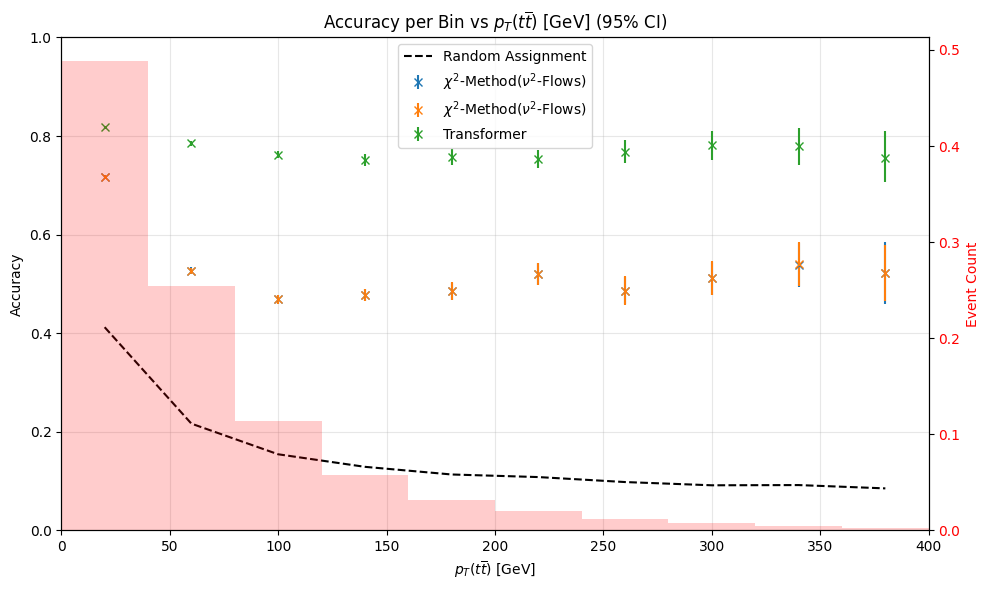

In [11]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


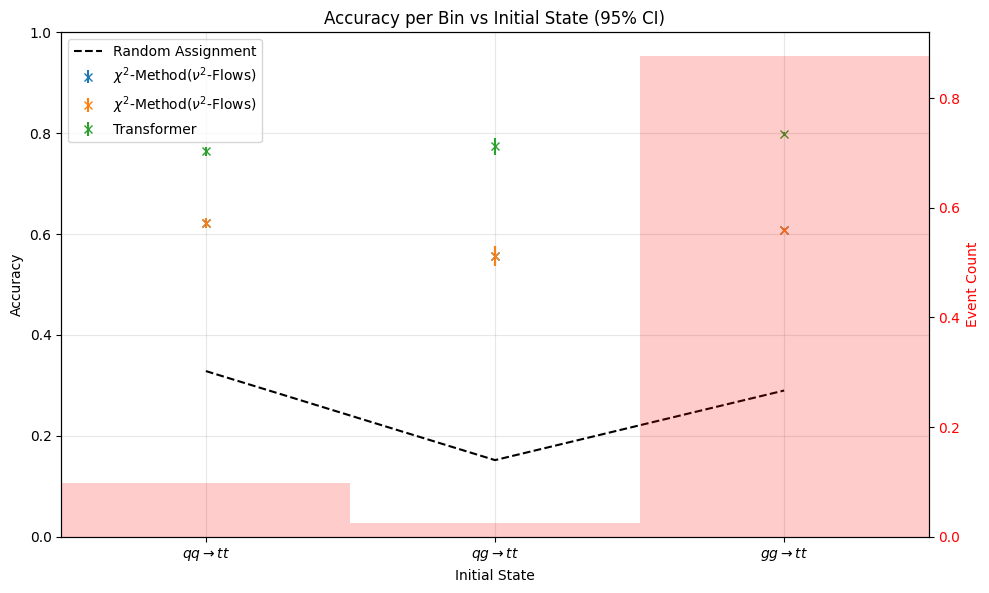

In [12]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for N_jets...


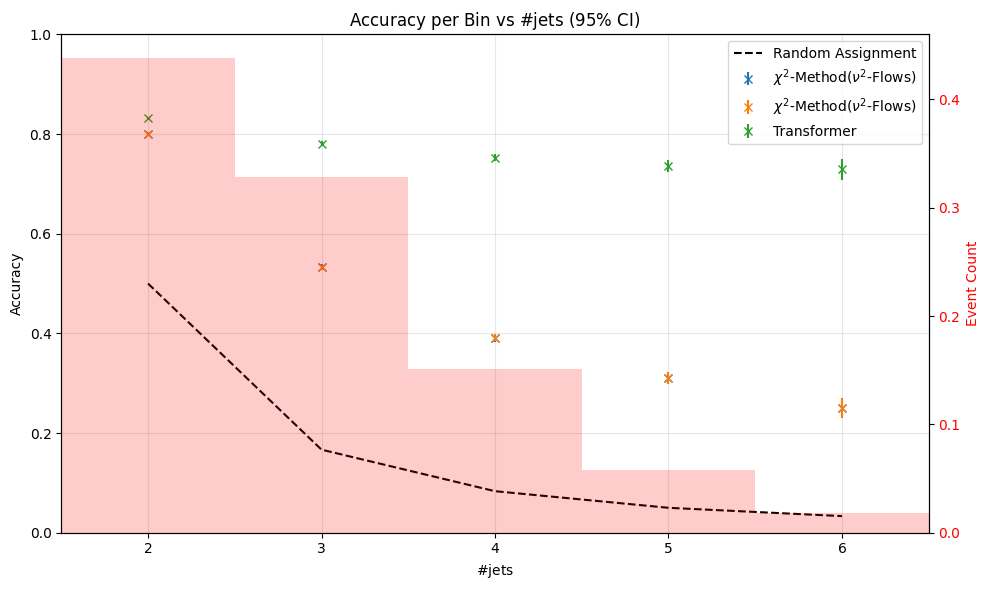

In [13]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

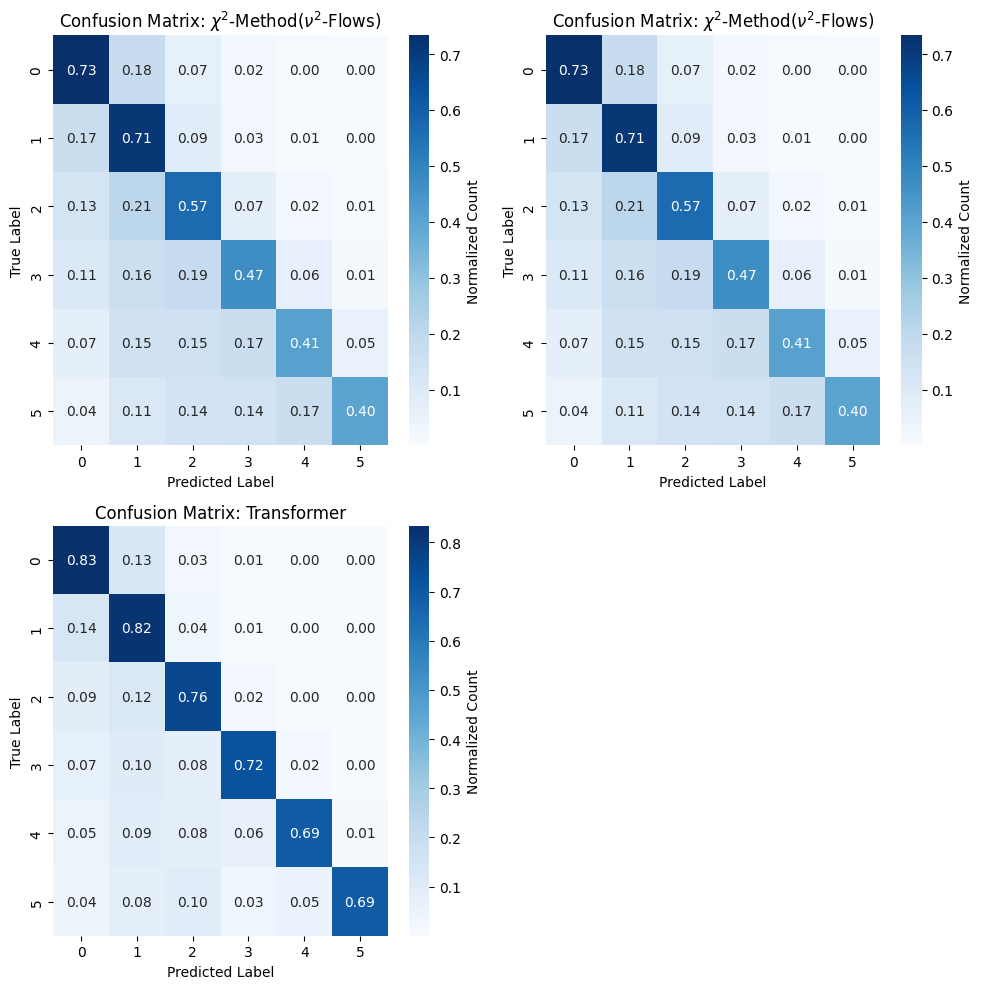

In [14]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

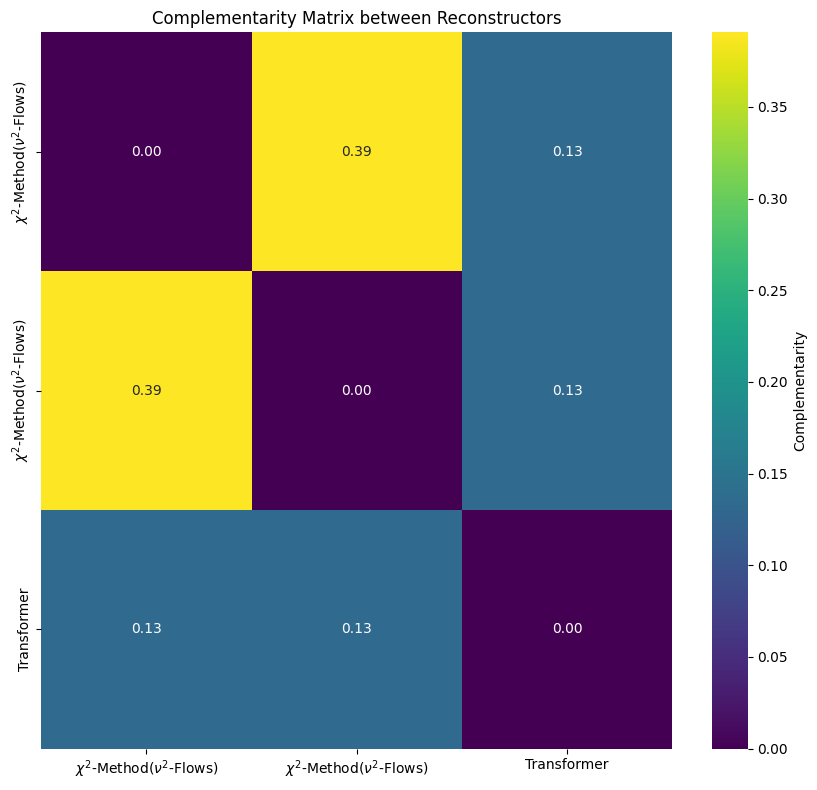

In [15]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")